# Processus gaussiens avec tinygp

Maintenant que nous avons exploré les GPs avec une implémentation à la main, il est temps d'utiliser une librairie plus robuste.
Nous utiliserons `tinygp`, qui est implémentée avec JAX.

Nous allons simplement répliquer un modèle simple comme celui du notebook précédent.


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

## Fonction de covariance

Commençons par définir une fonction de covariance (_kernel_) exponentielle carrée.

$$
k_{\mathrm{SE}}(x_i, x_j, \{\lambda\}) = \exp{\left(-\frac{1}{2\lambda^2}\left|x_i - x_j\right|^2\right)}
$$

Le module `tinygp.kernels` contient les fonctions de covariance.


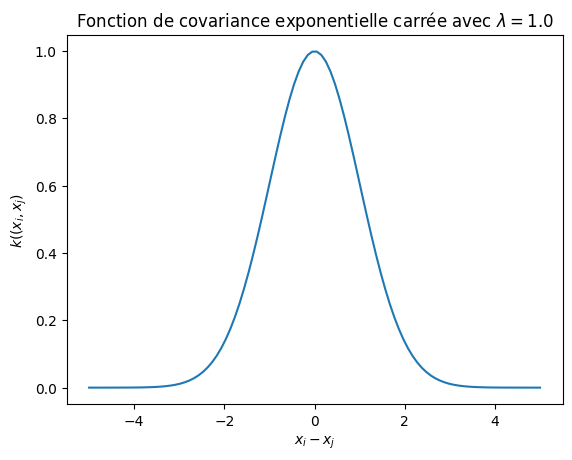

In [2]:
from tinygp import kernels

kernel = kernels.ExpSquared(1.0)

xi = jnp.linspace(-5, 5, num=100)
xj = jnp.array([0.0])  # les kernels attendent un tableau, pas un scalaire
k = kernel(xi, xj)

plt.plot(xi - xj, k)
plt.xlabel("$x_i - x_j$")
plt.ylabel("$k((x_i,x_j)$")
plt.title(r"Fonction de covariance exponentielle carrée avec $\lambda=1.0$")
plt.show()

On peut ensuite afficher la matrice de covariance

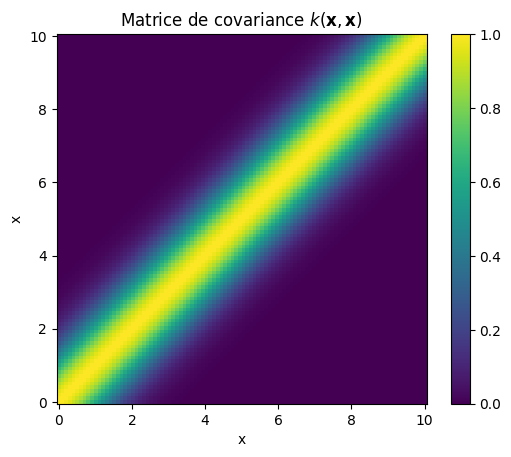

In [3]:
xi = jnp.linspace(0, 10, num=100)
kmat = kernel(xi, xi)  # kernel vectorise automatiquement sur les deux axes
plt.pcolormesh(xi, xi, kmat)
plt.xlabel("x")
plt.ylabel("x")
plt.title(r"Matrice de covariance $k(\mathbf{x},\mathbf{x})$")
plt.gca().set_aspect("equal")
plt.colorbar()
plt.show()

## Distribution a priori

Dans `tinygp`, les GPs sont définis par un objet `GaussianProcess`.
On spécifie une petite variance sur la diagonale pour éviter les erreurs numérique.
Par défaut, la moyenne du GP est de 0.

On peut ensuite utiliser la méthode `GaussianProcess.sample` pour obtenir des échantillons du prior.

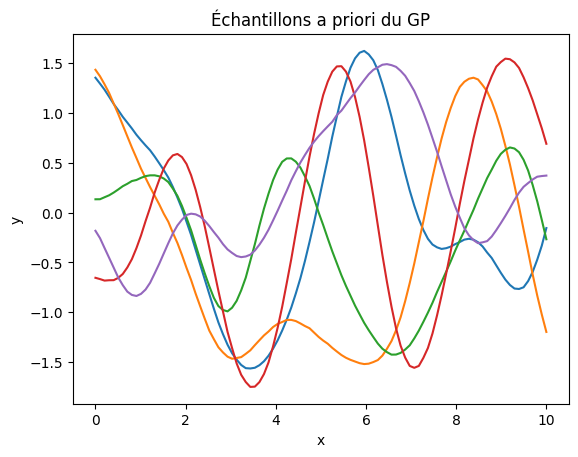

In [4]:
from tinygp import GaussianProcess

gp = GaussianProcess(kernel, xi, diag=1e-5)
gp_prior_samples = gp.sample(jax.random.key(8), shape=(5,))

plt.plot(xi, gp_prior_samples.T)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Échantillons a priori du GP")
plt.show()

### Distribution a posteriori (conditionnelle)

Comme avec notre exemple précédent, on peut simuler des observations et conditionner notre GP sur ces dernières.

**Testez différentes valeur pour l'hyperparamètre du kernel pour tester son impact sur les échantillons**.

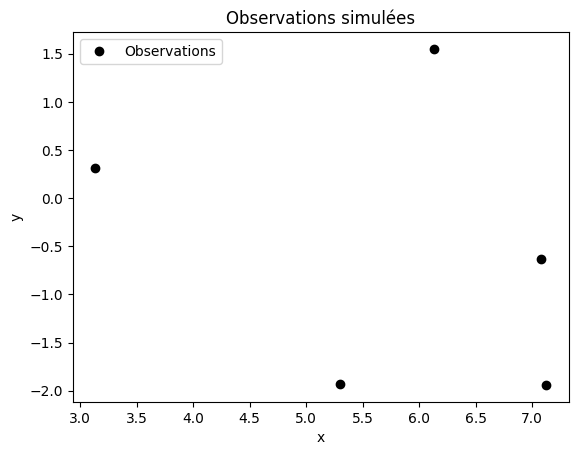

In [5]:
key, subkey1, subkey2 = jax.random.split(jax.random.key(514), num=3)
x = jax.random.uniform(subkey1, shape=5, minval=0.5, maxval=9.0)
y = jax.random.normal(subkey2, shape=x.shape)
xt = jnp.linspace(0, 10, num=100)

plt.plot(x, y, "ko", label="Observations")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Observations simulées")
plt.legend()
plt.show()

Pour conditionner le GP, on peut utiliser la méthode `GaussianProcess.condition`.
Cette dernière retourne un objet `ConditionResult` avec un argument `log_probability` (la vraisemblance du GP conditionné) et le GP conditionné.
On peut utiliser ce dernier pour générer des échantillons de la distribution a posteriori.

**Testez différentes valeurs pour `diag` afin de voir son impact sur la prédiction**

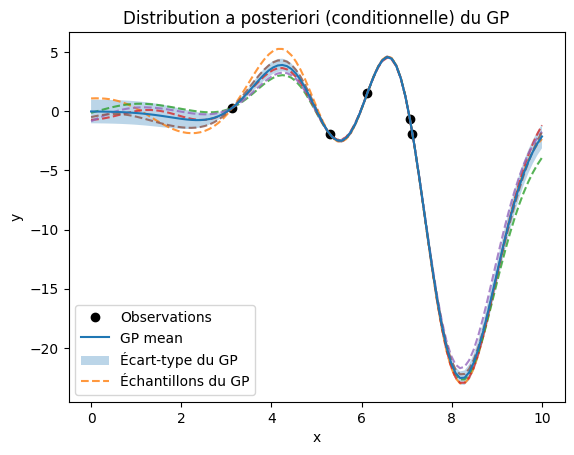

In [7]:
gp = GaussianProcess(kernel, x, diag=1e-4)
cond_logprob, cond_gp = gp.condition(y, xt)
fs = cond_gp.mean
f_std = jnp.sqrt(cond_gp.variance)
gp_post_samples = cond_gp.sample(jax.random.key(3), shape=(5,))

plt.plot(x, y, "ko", label="Observations")
plt.plot(xt, fs, label="GP mean", zorder=10)
plt.fill_between(xt, fs - f_std, fs + f_std, alpha=0.3, label="Écart-type du GP")
plt.plot(xt, gp_post_samples.T, "--", label=["Échantillons du GP"] + [None] * gp_post_samples[:-1].shape[0], alpha=0.8)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Distribution a posteriori (conditionnelle) du GP")
plt.show()

## Avec Fonction moyenne

Les GPs définis avec tinygp acceptent une fonction moyenne.
C'est utile pour définir un modèle physique autour duquel le GP génèrera du bruit.
Voici un exemple simple avec une droite.

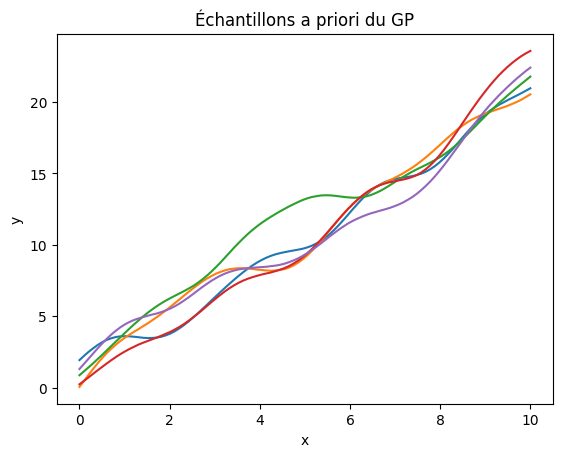

In [8]:
from tinygp import GaussianProcess

def mean_function(x):
    return 2.0 * x + 1.0

gp = GaussianProcess(kernel, xi, diag=1e-5, mean=mean_function)
gp_prior_samples = gp.sample(jax.random.key(246), shape=(5,))

plt.plot(xi, gp_prior_samples.T)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Échantillons a priori du GP")
plt.show()

## Vraisemblance et optimisation des hyperparamètres

Pour optimiser les hyperparamètres d'un GP, on utilisera typiquement l'attribut `log_probability`.
Pour tirer avantage de la compilation just-in-time avec JAX, il est commun de construire le GP dans une fonction et d'utiliser cette fonction dans une autre fonction `loss` qui définit la fonction "objectif" à minimiser (log-likelihood négatif, typiquement).

In [10]:
def build_gp(params, x):
    kernel = kernels.ExpSquared(
        jnp.exp(params["log_scale"])
    )
    return GaussianProcess(kernel, x, diag=jnp.exp(params["log_diag"]))


@jax.jit
def neg_log_likelihood(params, x, y):
    gp = build_gp(params, x)
    return -gp.log_probability(y)


params = {
    "log_scale": 0.0,
    "log_diag": -1.0,
}
neg_log_likelihood(params, x, y)

Array(13.5686632, dtype=float64)

La librairie `jaxopt` a une interface similaire à scipy pour l'optimisation:

In [12]:
import jaxopt

solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(params, x, y)
print(f"Final negative log likelihood: {soln.state.fun_val}")
print(f"Final parameters {soln.params}")

Final negative log likelihood: 8.727639800570753
Final parameters {'log_diag': Array(-0.03536588, dtype=float64), 'log_scale': Array(-1.56610092, dtype=float64)}


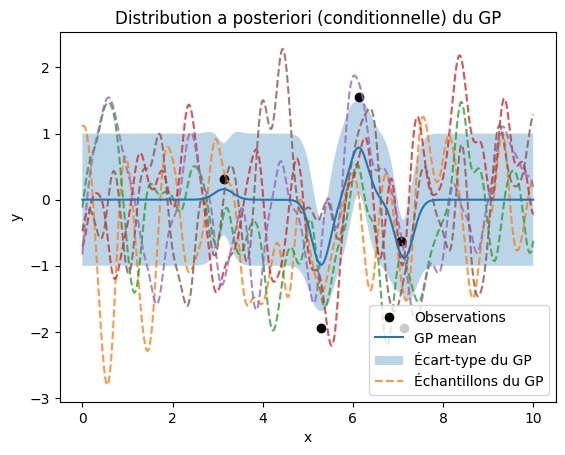

In [13]:
gp = build_gp(soln.params, x)
xt = jnp.linspace(0, 10, num=1000)
cond_logprob, cond_gp = gp.condition(y, xt)
fs = cond_gp.mean
f_std = jnp.sqrt(cond_gp.variance)
gp_post_samples = cond_gp.sample(jax.random.key(3), shape=(5,))

plt.plot(x, y, "ko", label="Observations")
plt.plot(xt, fs, label="GP mean", zorder=10)
plt.fill_between(xt, fs - f_std, fs + f_std, alpha=0.3, label="Écart-type du GP")
plt.plot(xt, gp_post_samples.T, "--", label=["Échantillons du GP"] + [None] * gp_post_samples[:-1].shape[0], alpha=0.8)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Distribution a posteriori (conditionnelle) du GP")
plt.show()

Ici le fit n'est pas particulièrement bon, entre autres car on a peu de données, mais il montre tout de même la base pour optimiser un modèle GP avec tinygp.